# Scikit-learn Example

### Load libraries

Note the difference between `import` and `from` x `import` y

In [1]:
import pandas as pd
import numpy as np

import sklearn.datasets as datasets
from sklearn.model_selection import train_test_split

### Load in data

In [2]:
boston = datasets.load_boston()

### EDA

In [3]:
list(boston.keys())

['data', 'feature_names', 'target', 'DESCR']

In [4]:
boston['feature_names']

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], 
      dtype='<U7')

In [5]:
from scipy import stats

y = boston['target']

stats.describe(y)

DescribeResult(nobs=506, minmax=(5.0, 50.0), mean=22.532806324110677, variance=84.586723594098558, skewness=1.104810822864635, kurtosis=1.4686287722747462)

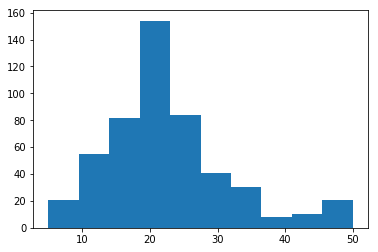

In [6]:
import matplotlib.pyplot as plt
plt.hist(y)
plt.show()

## Split into training and test data sets

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
          boston['data']
        , boston['target']
        , test_size=0.33
        , random_state=42
)

### Simple Linear Regression example

ESTIMATOR.fit(predictors, response)

In [8]:
import sklearn.linear_model as lm

linear_regression = lm.LinearRegression().fit(X_train, y_train)

Model R_Square on the holdout:

In [9]:
linear_regression.score(X_test, y_test)

0.72585158182300469

BAF note: is there a summary function in scikit-learn that would work better here? I'm thinking of something analogous to R's `summary()` function.

In [10]:
pd.DataFrame(
      np.array([boston['feature_names'], linear_regression.coef_]).T
    , columns = ['Feature','Coefficient']
)

,Feature,Coefficient
0,CRIM,-0.12806039830227736
1,ZN,0.037795569275776555
2,INDUS,0.05861077967791607
3,CHAS,3.240070073436767
4,NOX,-16.222267596612692
5,RM,3.8935224412487948
6,AGE,-0.012787994352285318
7,DIS,-1.4232686401061765
8,RAD,0.23451308179194089
9,TAX,-0.008202611267236669


Each estimator in `sklearn` has  `fit()`, `predict()`, and `score()` methods. This makes swapping techniques easy.

ESTIMATOR.fit(predictors, response)
ESTIMATOR.predict(predictors, response)
ESTIMATOR.score(predictors, response)

Let's fit an OLS, ridge, lasso, elasticnet, random forest, gradient boost and decision tree

BAF: In the data frame that we're printing, can we sort the models in descending order by R^2?

In [11]:
import sklearn.ensemble as ens
import sklearn.tree as tree

max_iter = 100000
random_state = 42

linear_models = [
      lm.LinearRegression() 
    , lm.Ridge(max_iter = max_iter)
    , lm.Lasso(max_iter = max_iter)
    , lm.ElasticNet(max_iter = max_iter)
    , ens.RandomForestRegressor(random_state=random_state)
    , ens.GradientBoostingRegressor(random_state=random_state)
    , tree.DecisionTreeRegressor(random_state=random_state)
]

model_names = [type(model).__name__ for model in linear_models]

fitted_models = [model.fit(X_train, y_train) for model in linear_models]

model_r2 = [model.score(X_test,y_test) for model in fitted_models]

results = pd.DataFrame([model_names, model_r2], index=['Model','R2 Initial']).T

results

,Model,R2 Initial
0,LinearRegression,0.725852
1,Ridge,0.720131
2,Lasso,0.664381
3,ElasticNet,0.668769
4,RandomForestRegressor,0.812672
5,GradientBoostingRegressor,0.893198
6,DecisionTreeRegressor,0.740223


The linear models do not fare as well as the ensemble techniques.  This is likely due to non-linear relationships in the underlying featureset.

## Preprocess data

Scikit-learn has a variety of transformers that take raw data and generate transformations that are better suited for certain algorithms.

These transformers include StandardScaler(), PCA(), Imputer(), LabelBinarizer(), PolynomialFeature(), and so much more...

Transformers are estimators too and have fit() methods to set up the transformation as well as transform() method to apply it to new data.

*** figure out a sexy way to show how comprehensive the toolkit is in feature engineering/data preprocessing capabilities.

In [12]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
poly.fit(X_train)

X_train_transform = poly.transform(X_train)
X_test_transform = poly.transform(X_test)

In [13]:
print('By adding 2nd degree terms to our feature set we expand our featureset from ' + str(len(boston['feature_names'])) + \
      ' features to ' + str(len(poly.get_feature_names())) + '.')

fitted_models = [model.fit(X_train_transform,y_train) for model in linear_models]

model_r2 = [model.score(X_test_transform,y_test) for model in fitted_models]

results = results.T.append(pd.Series(model_r2, name='R2 Poly')).T

results

By adding 2nd degree terms to our feature set we expand our featureset from 13 features to 105.


,Model,R2 Initial,R2 Poly
0,LinearRegression,0.725852,0.486611
1,Ridge,0.720131,0.662576
2,Lasso,0.664381,0.838244
3,ElasticNet,0.668769,0.842125
4,RandomForestRegressor,0.812672,0.825092
5,GradientBoostingRegressor,0.893198,0.887188
6,DecisionTreeRegressor,0.740223,0.74719


### Scikit-learn is customizable

You can even work your own transformers into the workflow.  Let's explore taking the natural log of our featureset.

In [14]:
from sklearn.preprocessing import FunctionTransformer

transformer = FunctionTransformer(np.log1p)

X_train_transform = np.append(X_train,transformer.transform(X_train), axis=1)
X_test_transform = np.append(X_test,transformer.transform(X_test), axis=1)

fitted_models = [model.fit(X_train_transform,y_train) for model in linear_models]

model_r2 = [model.score(X_test_transform,y_test) for model in fitted_models]

results = results.T.append(pd.Series(model_r2, name='R2 Log')).T

results

,Model,R2 Initial,R2 Poly,R2 Log
0,LinearRegression,0.725852,0.486611,0.822088
1,Ridge,0.720131,0.662576,0.786281
2,Lasso,0.664381,0.838244,0.664378
3,ElasticNet,0.668769,0.842125,0.669214
4,RandomForestRegressor,0.812672,0.825092,0.824317
5,GradientBoostingRegressor,0.893198,0.887188,0.895237
6,DecisionTreeRegressor,0.740223,0.74719,0.727383


# Scikit-learn is a scalable workflow

### Pipelining

The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters.  Pipelines are estimators too with fit(), predict() and score() methods. 


DATA --> TRANSFORM --> FIT

An example of a simple pipeline chaining polynomial transform and lasso regression together.

In [15]:
from sklearn.pipeline import Pipeline

poly = PolynomialFeatures(2)
lasso = lm.Lasso(max_iter=100000)

pipe = Pipeline(
    steps = [('poly', poly), ('lasso', lasso)]
)

pipe.fit(X_train, y_train)

print('Holdout score:' + str(pipe.score(X_test, y_test)))

Holdout score:0.838244117471


### Pipelining with GridSearchCV

The real power of pipelines is realized when using them with GridSearchCV - The beauty here is that both transformers and the model maintain data separability between the train and test of each fold in the cross-validation routine.  This ensures no data leakage in evaluating estimator performance, but allows us to refine the hyperparameters of all estimators in the pipeline.

### Optimize our DecisionTreeRegressor

DATA --> TRANSFORM --> SPLIT --> GRID_SEARCH.fit()

In [16]:
from sklearn.model_selection import GridSearchCV

dtree = tree.DecisionTreeRegressor(random_state = random_state)

pipe = Pipeline(
    steps=[
          ('poly', poly)
        , ('dtree', dtree)
    ]
)

param_grid = dict(
      dtree__criterion = ['mse','friedman_mse']
    , dtree__max_depth = [25, 50, 75, 100]
    , dtree__min_samples_leaf = [2, 3, 5, 10]
    , dtree__min_samples_split = [5,10,20]
    , poly__degree = [1,2])

estimator = GridSearchCV(pipe, param_grid, return_train_score = True, cv = 5)
estimator.fit(X_train, y_train)

parameters = pd.DataFrame(estimator.cv_results_['params'])

cv_test_scores = pd.Series(estimator.cv_results_['mean_test_score'],name='mean_test_score')

parameters.T.append(cv_test_scores).T.sort_values('mean_test_score', ascending=False).head(5)

PandasError: DataFrame constructor not properly called!

Let's retrain the decision tree on our training set with the optimal hyper-parameters from the GridSearch space and verify holdout score.

In [17]:
poly = PolynomialFeatures(2)

dtree = tree.DecisionTreeRegressor(
      criterion = 'friedman_mse'
    , max_depth = 50
    , min_samples_leaf = 3
    , min_samples_split = 20
    , random_state = random_state
)

pipe = Pipeline(
    steps=[
          ('poly', poly)
        , ('dtree', dtree)
    ]
)

pipe.fit(X_train, y_train)
print('An optimized pipeline for our Decision Tree Regressor produces a holdout score of ' + str(pipe.score(X_test, y_test)))

An optimized pipeline for our Decision Tree Regressor produces a holdout score of 0.819812808935
